# **Tensorflow Example**

#### 이 파일은 "stockait" 라이브러리를 사용하여 주가 데이터에 대한 딥러닝 모델링 예시를 보여준다. 그 중에서도 **tensorflow/keras** 프레임워크를 사용하는 튜토리얼이다. 

<br> 


In [1]:
import sys
sys.path.append("/project/stockAI/github/main/stockait")
import stockait as sai
import pandas as pd
from tensorflow import keras
import numpy as np

2023-09-06 11:12:12.619325: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 11:12:13.044076: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-06 11:12:14.347751: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64::/usr/local/cuda-11.5/lib64:/usr/local/cuda-11.5/targets/x86_64-linux/lib
2023-09-06 11:12:14.347881: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dyna

--------

<br> 
<br> 

# **1. Load Data**

#### 데이터 로드 및 전처리 과정은 생략하고, `00.demo.ipynb` 파일 에서 저장한 데이터로 연구를 진행한다.  
#### 데이터는 다음의 두 가지가 존재한다. 
- time_series_0903.parquet 
- time_series_0903_scaled.parquet (스케일링 적용 데이터 / div-close 방법) 

#### 스케일링을 제외하고는 모두 같은 방법으로 전처리가 적용되어있다. 

In [2]:
df_time_series = pd.read_parquet("time_series_0903.parquet") 
df_time_series_scaled = pd.read_parquet("time_series_0903_scaled.parquet")

df_time_series['Code'] = df_time_series['Code'].astype(str).str.zfill(6)
df_time_series_scaled['Code'] = df_time_series_scaled['Code'].astype(str).str.zfill(6)

In [4]:
print(df_time_series.shape) 
df_time_series.head()

(1045449, 483)


,Code,Date,D-9_Open,D-9_High,D-9_Low,D-9_Close,D-9_Volume,D-9_Change,D-9_MA5,D-9_MA20,...,D0_TSI,D0_UO,D0_SR,D0_WR,D0_AO,D0_KAMA,D0_ROC,D0_PPO,D0_PVO,next_change
index,,,,,,,,,,,,,,,,,,,,,
0,000020,2017-01-02,8000,8020,7880,7980,29259,-0.002500,7928.0,7773.0,...,8.733155,63.290816,86.956522,-13.043478,142.823529,7862.703851,2.658228,0.653934,-1.629817,0.000000
1,000020,2017-01-03,7980,8000,7830,7920,25678,-0.007519,7948.0,7770.0,...,10.392942,64.061001,86.363636,-13.636364,183.794118,7872.320017,2.141058,0.753873,-5.174549,0.004932
2,000020,2017-01-04,7880,7960,7830,7900,34333,-0.002525,7948.0,7768.5,...,12.273619,67.101325,91.111111,-8.888889,219.529412,7898.574543,1.875000,0.862988,-1.907365,0.007362
3,000020,2017-01-05,7900,7910,7740,7800,49362,-0.012658,7920.0,7766.5,...,14.587203,64.966439,92.156863,-7.843137,255.705882,7941.330237,2.882206,0.997655,-2.485440,-0.006090
4,000020,2017-01-06,7800,7940,7760,7830,31948,0.003846,7886.0,7759.0,...,15.671728,60.791157,75.000000,-25.000000,285.500000,7985.928857,3.030303,1.041458,-3.459170,-0.009804


#### 날짜는 2017년 1월 1일 부터 2021년 12월 31일까지이며, 총 42개의 보조지표를 추가한 데이터이다. 또한 하나의 행에는 10일치의 주가 데이터, 보조지표 컬럼이 존재한다. Code, Date, next_change(종속변수)를 제외하고, 총 480개의 독립변수를 가지는 것을 볼 수 있다.   

### **train / validation / test 데이터셋 분리** 

In [4]:
data = df_time_series # Data Before Scaling
data_scaled = df_time_series_scaled # Data After Scaling

# train, validation, test dataset split
train_data = data[(data['Date'] >= '2017-01-01') & (data['Date'] <= '2020-12-31')]
valid_data = data[(data['Date'] >= '2021-01-01') & (data['Date'] <= '2021-06-31')] 
test_data = data[(data['Date'] >= '2021-07-01') & (data['Date'] <= '2021-12-31')]

# train, validation, test dataset split (scaled) 
train_data_scaled = data_scaled[(data_scaled['Date'] >= '2017-01-01') & (data_scaled['Date'] <= '2020-12-31')]
valid_data_scaled = data_scaled[(data_scaled['Date'] >= '2021-01-01') & (data_scaled['Date'] <= '2021-06-31')] 
test_data_scaled = data_scaled[(data_scaled['Date'] >= '2021-07-01') & (data_scaled['Date'] <= '2021-12-31')]

print(train_data.shape, valid_data.shape, test_data.shape)
print(train_data_scaled.shape, valid_data_scaled.shape, test_data_scaled.shape)

(828290, 483) (107068, 483) (110091, 483)
(828290, 483) (107068, 483) (110091, 483)


#### 2017년 부터 2020년을 학습 데이터셋으로, 2021년 6월까지 검증 데이터셋, 2021년 12월까지 시험 데이터셋으로 설정하여 분할했다. 

<br> 
<br> 

# **2. Trader Definition**
#### keras 프레임워크를 사용하여 딥러닝 모델을 포함하는 트레이더를 정의한다. 이 tutorial에서는 LSTM과 Transformer 모델을 사용하여 주가 빅데이터 연구를 진행한다. 

### * **GPU 설정** 

In [4]:
import os
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

2023-09-04 10:23:03.157909: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-04 10:23:03.215748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-04 10:23:03.217186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


#### 이전 tutorial에서 수행했던 것 처럼 빈 리스트 lst_trader를 하나 생성하고, 생성된 lst_trader 안에 우리가 정의 할 트레이더 객체들을 넣어준다.

In [5]:
lst_trader = [] 

<br> 

## **1) LSTM**
#### 간편하게 하나의 셀에 트레이더를 간편하게 정의해줄 수 있는 것이 "stockAIT"의 장점 중 하나이다. 하지만 이번 tutorial에서는 더 쉬운 이해를 위해 6개의 셀로 나누어 진행하겠다.

### **ConditionalBuyer 객체와 sampling 함수 정의** 
#### ConditionalBuyer에서 주가 데이터를 필터링 할 조건을 설정하는 함수 sampling을 직접 정의한다. 종가 변화율이 30% 이상이면 제외하며, 종가 변화율이 너무 낮은 -0.05 ~ 0.05 인 데이터는 제외하고, 거래대금이 10억 이상인 데이터셋만을 사용하도록 조건을 생성했다. 

In [6]:
b1_ls = sai.ConditionalBuyer()

def sampling1(df): 
    condition1 = (-0.3 <= df.D0_Change) & (df.D0_Change <= 0.3) 
    condition2 = (df.D0_Close * df.D0_Volume) >= 1000000000 
    condition3 = (-0.05 >= df.D0_Change) | (0.05 <= df.D0_Change) 
    condition = condition1 & condition2 & condition3  
    return condition

b1_ls.condition = sampling1

### **MachinelearnigBuyer 객체 정의** 
#### Machinelearning Buyer는 인공지능 모델 학습을 담당한다. 인공지능 모델과 관련된 정보들은 모두 Machinelearning Buyer 객체의 속성에 넣어줘야 한다. 

In [7]:
b2_ls = sai.MachinelearningBuyer()

#### 첫번째로, 데이터를 3차원으로 변환해주는 함수를 저장하는 **data_transform** 속성이다. 

### **transform 함수 정의** 
#### 아래의 그림을 보면, 현재 우리가 갖고 있는 주가 데이터의 모양이 왼쪽에 나와있다. 
#### 원래 데이터의 shape은 **(828290, 483)** 이었다. 이를 딥러닝 모델에 넣어주기 위하여 3차원 shape으로 변환해야한다. 

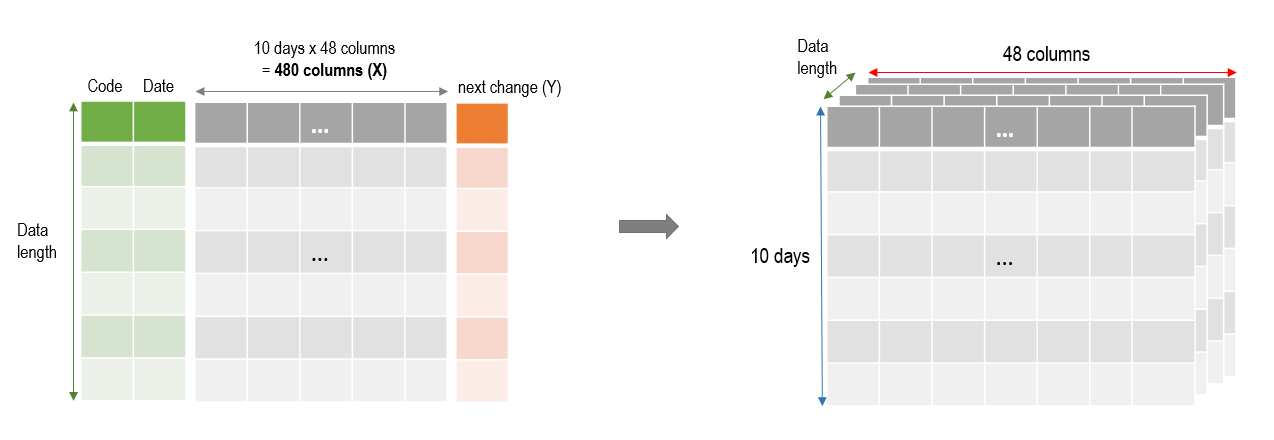

#### 즉, 하나의 행에 총 **10일 x 48개 컬럼 = 480개의 컬럼** 으로 이루어져있던 종속변수를 (data_length, sequence_length, dimension) 으로 변환하여 3차원인 **(828290, 10, 48)** 의 shape으로 만들어주는 작업이다. 

In [8]:
# User-defined functions (users who want deep learning modeling)
def transform1(data): # A function that converts into a two-dimensional structure / data: list (lst_time_series)
    data_2d = []
    n_col = int(len(data[0]) / 10) 
    for row in data:      
        data_2d.append([])
        for i in range(0, len(row), n_col):
            data_2d[-1].append(row[i:i+n_col])
    
    return np.array(data_2d)
    

# Directly define a two-dimensional structure transformation function (transform) and store it in the data_transform property
b2_ls.data_transform = transform1 

#### 3차원 데이터로 변환하는 함수를 정의했으면, data_transform 속성에 추가해준다.  
#### 그 다음으로는 Machinelearning Buyer 객체의 핵심인 딥러닝 모델을 정의한다. 

### **딥러닝 모델 정의**
#### 딥러닝 모델을 정의할 때는 먼저 `framework`속성에 어떤 프레임워크를 사용할 것인지 명시한다.
#### 그 다음 keras의 model.fit() 메서드의 매개변수로 들어갈 값들을 `parms` 속성에 dictionary 형태로 넣어준다. 마지막으로 딥러닝 모델을 정의하고, compile 코드를 작성한다. 
#### 우리는 다음날 종가가 2% 이상 올랐는지를 예측하는 이진분류 모델을 생성해야하므로, 마지막 층은 1개의 유닛과 sigmoid 활성화 함수를 사용한다. 손실함수도 그에 맞게 binary_crossentropy를 사용한다. 

In [9]:
from keras.callbacks import EarlyStopping

# deep learning framework 
b2_ls.framework = "tensorflow"

# parameters for model.fit() 
early_stopping = EarlyStopping(monitor='val_loss', patience=7)
b2_ls.params = {
    "epochs": 20, 
    "batch_size": 64,
    "callbacks": [early_stopping]
    }

#model.add(keras.layers.Dropout(0.2))
# defines a model 
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=(10, 48)))
model.add(keras.layers.LSTM(128, activation='selu', return_sequences=True))
model.add(keras.layers.LSTM(64, activation='selu', return_sequences=True))
model.add(keras.layers.LSTM(32, activation='selu', return_sequences=False))
model.add(keras.layers.Dense(1, activation='sigmoid'))
    
model.compile(optimizer=keras.optimizers.Adam(
    # learning_rate=keras.optimizers.schedules.ExponentialDecay(0.05,decay_steps=100000,decay_rate=0.96)), 
    learning_rate = 0.001), 
    loss="binary_crossentropy",
    metrics=['accuracy'])

b2_ls.algorithm = model

2023-09-04 10:23:11.494989: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 10:23:11.637669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-04 10:23:11.639195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-04 10:23:11.640480: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

#### 모델과 관련된 정보들을 모두 설정하였으면, 정의한 모델을 `algorithm` 속성에 넣어준다. 
#### Buyer 의 서브 객체들인 Conditional Buyer와 Machinelearning Buyer를 모두 정의해주었고, 이번에는 Seller의 서브 객체인 SubSeller를 정의한다. 

### **SubSeller 객체 정의** 
#### SubSeller 객체는 매수한 주식을 매수 날짜 다음날에 모두 되파는 방법만을 제공하고있다. 이러한 SubSeller 객체를 하나 생성해준다. 

In [10]:
sell_all = sai.SubSeller() 

#### 이제 트레이더를 정의할 준비를 모두 끝마쳤다. 

### **트레이더, Buyer, Seller 객체 정의** 
#### 트레이더 객체에는 트레이더를 구분하기 위한 `name` 속성, 종속변수를 설정하는 `label` 속성, Buyer, Seller 객체를 저장하는 `buyer` 속성과 `seller` 속성이 있다. 

In [11]:
t4 = sai.Trader()
t4.name = 'saiLSTM_tf' 
t4.label = 'class&0.02' 
t4.buyer = sai.Buyer([b1_ls, b2_ls]) 
t4.seller = sai.Seller(sell_all)

lst_trader.append(t4)

#### 여기서 label을 보면, "class&0.02"라고 작성되어있는데, **classification** 문제이며, **다음날 종가 변화율**이 **0.02** 이상이면 1, 그렇지 않으면 0으로 이진분류한다는 뜻이다. 분류로 하고싶지 않으면 "reg"라고 설정하여, 다음날 종가 변화율 (next_change) 자체를 종속변수로 사용할 수 있다. 
#### buyer에는 Buyer 객체를 호출할 때 리스트 안에 위에서 정의했던 conditional buyer와 machinelearning buyer를 넣고, seller는 바로 SubSeller 객체를 넣어준다. 

<br> 

#### 지금까지 keras 프레임워크로 LSTM 모델을 포함한 트레이더를 정의했다. 아래에는 Transformer 모델링을 진행한다.  

## **2) Transformer**
#### Transformer는 하나의 셀에 작성하였으며, 위의 LSTM 과 모든 방법이 동일하다. 다른 점은 `algorithm` 속성에 들어가는 모델의 구조 뿐이다. 

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

import numpy as np 

b1_tr = sai.ConditionalBuyer()

def sampling6(df): 
    condition1 = (-0.3 <= df.D0_Change) & (df.D0_Change <= 0.3) 
    condition2 = (df.D0_Close * df.D0_Volume) >= 100000000 
    condition3 = (-0.05 >= df.D0_Change) | (0.05 <= df.D0_Change) 
    condition = condition1 & condition2 & condition3
    return condition

b1_tr.condition = sampling6


b2_tr = sai.MachinelearningBuyer()

# User-defined functions (users who want deep learning modeling)
def transform(data): # A function that converts into a two-dimensional structure / data: list (lst_time_series)
    data_2d = []
    n_col = int(len(data[0]) / 10) 
    for row in data:      
        data_2d.append([])
        for i in range(0, len(row), n_col):
            data_2d[-1].append(row[i:i+n_col])
    
    return np.array(data_2d)
    

# Directly define a two-dimensional structure transformation function (transform) and store it in the data_transform property
b2_tr.data_transform = transform 

# deep learning framework 
b2_tr.framework = "tensorflow"

# parameters for model.fit() 
b2_tr.params = {
    "epochs": 10, 
    "batch_size": 64,
    }

##### defines a model ##### 
def transformer_encoder(inputs, d_model, num_heads, ff_dim, num_blocks, dropout=0.1):
    # Multi-head self-attention layer
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=d_model, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + inputs)
    
    # Feedforward neural network
    ffn = tf.keras.Sequential([
        tf.keras.layers.Dense(ff_dim, activation='relu'),
        tf.keras.layers.Dense(d_model),
    ])
    x = ffn(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + inputs)
    
    return x

def build_transformer_model(input_shape, d_model, num_heads, ff_dim, num_blocks, dropout=0.1):
    inputs = Input(shape=input_shape)
    x = inputs
    # x = Embedding(input_dim=input_shape[0], output_dim=d_model)(inputs)
    
    for _ in range(num_blocks):
        x = transformer_encoder(x, d_model, num_heads, ff_dim, dropout)
    
    x = GlobalAveragePooling1D(data_format='channels_last')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# 모델 파라미터 설정
input_shape, d_model, num_heads, ff_dim, num_blocks = (10, 48), 48, 6, 256, 2 

# 트랜스포머 모델 빌드
model = build_transformer_model(input_shape, d_model, num_heads, ff_dim, num_blocks)

# model compile     
model.compile(optimizer=keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.ExponentialDecay(0.05, decay_steps=100000, decay_rate=0.96)), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

b2_tr.algorithm = model

sell_all = sai.SubSeller() 

t6 = sai.Trader()
t6.name = 'saiLSTM_tf' 
t6.label = 'class&0.02' 
t6.buyer = sai.Buyer([b1_tr, b2_tr]) 
t6.seller = sai.Seller(sell_all)

lst_trader.append(t6)

<br>

### 위의 과정을 모두 거치면, lst_trader 안에 트레이더들이 들어가게 되고, 모델 학습 파트 함수의 인자에는 lst_trader를 넣어주어 각 trader 단위로 연산을 수행하게 된다. 

<br> 
<br> 

# **3. Trader(Model) Fitting & Evauation**

## **1) Save Dataset to Traders** 

#### lst_trader와 데이터 (original / scaled 데이터셋의 train / valid / test 데이터셋) 를 인자에 넣어주면 각 트레이더 내부에 데이터셋이 저장된다. 
#### (이 때, scaled 데이터셋과 valid 데이터셋은 필수가 아님.)

In [14]:
sai.save_dataset(lst_trader, train_data, valid_data, test_data, train_data_scaled, valid_data_scaled, test_data_scaled)

<br> 

## **2) Model fitting**

#### 각각의 트레이더 별로 모델 학습을 진행한다. 
#### `history=True` 로 설정하면, 학습과 더불어 validation 데이터셋 평가가 함께 진행되며, 아래에서 history와 학습 곡선을 그릴 수 있다. 

In [5]:
sai.trader_train( lst_trader, history=True) 

<br> 

## **3) get history & learning Curve** 
#### history=True로 했을 때 이용 가능한 함수이다. history dictionary가 리턴되며, 동시에 학습 곡선 그래프를 출력한다. 

In [ ]:
dic_history = sai.get_history_learning_curve(lst_trader)

In [ ]:
dic_history

<br> 

## **4) Model evaluation and threshold settings**
### **Model evaluation**
#### 각각의 트레이더 별로 임계값 마다의 평가지표를 시각화 한다.  

In [ ]:
sai.get_eval_by_threshold(lst_trader)

### **threshold settings**
#### 위에서 평가지표 시각화를 토대로 주식을 매수 할 예측 확률 임계값을 설정한다. 
#### histogram=True로 설정하면 validation 데이터셋으로 얼마큼의 수익을 얻을 수 있을지 검증하는 histogram이 함께 출력된다. lst_threshold 인자에 임계값을 바꿔보며 검증된 수익성으로 임계값을 판단할 수 있다. 
#### 아래의 그래프를 예로 들어 임계값이 0.5 라면, 예측 확률이 0.5 이상인 데이터들의 다음 날 종가 변화율의 평균이 0.571 이므로 0.571 만큼의 수익률을 기대할 수 있다.  

241/241 [==============================] - 3s 13ms/step


<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

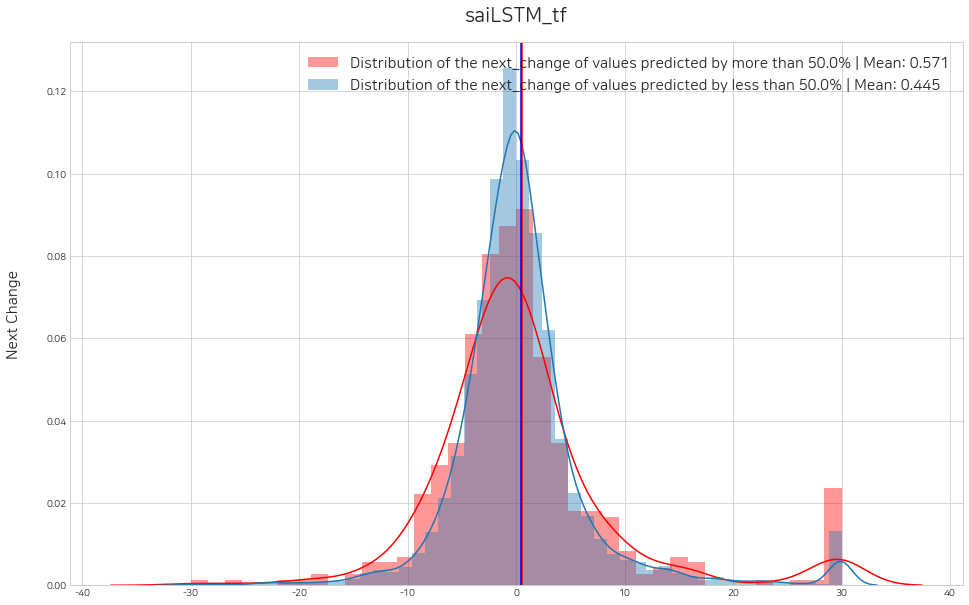

In [24]:
sai.set_threshold(lst_trader, lst_threshold=[0.5], histogram=True)

<br> 
<br> 

# **4. Back-Testing**

## **1) Making a sales log**
#### 각각의 트레이더로, 모든 날짜에 대한 매수, 매도 기록을 생성한 매매일지를 df_signal_all에 넣어준다.  

In [ ]:
df_signal_all = sai.decision(lst_trader, dtype='test')
df_signal_all

<br> 

## **2) Simulation: Calculate the yield**
#### 위에서 구한 매매일지 **df_signal_all**을 토대로 각 트레이더에 대한 수익률을 계산한다. 
#### `init_budget` 인자에 초기 예산을 입력하고, `fee` 인자에 수수료를 넣어준다. 

In [ ]:
df_history_all = sai.simulation(df_signal_all, init_budget=10000000, init_stock={}, fee=0.01)
df_history_all

<br> 

## **3) Leader Board**
#### 트레이더의 수익률 결과를 내림차순으로 정렬하여 데이터프레임 형태의 리더보드를 볼 수 있다. 
#### 결과는 ~~ 와 같이 나왔다. 

In [ ]:
sai.leaderboard(df_history_all)

<br> 

## **4) Visualize Results**
#### 트레이더 별로 모든 날짜에 대한 수익률 시각화를 볼 수 있다. 

In [ ]:
sai.yield_plot(df_history_all)

#### 결과는 ~~ 이렇다 